# Data Exploration

In [232]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.rcParams['figure.figsize'] = (16, 9)



In [233]:
!ln -s ../utils/functions.py functions.py
from functions import get_the_original_data, get_transition_matrix

ln: functions.py: File exists


In [323]:
supermarket = get_the_original_data()
supermarket.head()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices


## Calculate the total number of customers in each section

In [324]:
customers_per_section = supermarket.groupby('location').count()
customers_per_section

,customer_no
location,
checkout,7417
dairy,4679
drinks,3905
fruit,5122
spices,3754


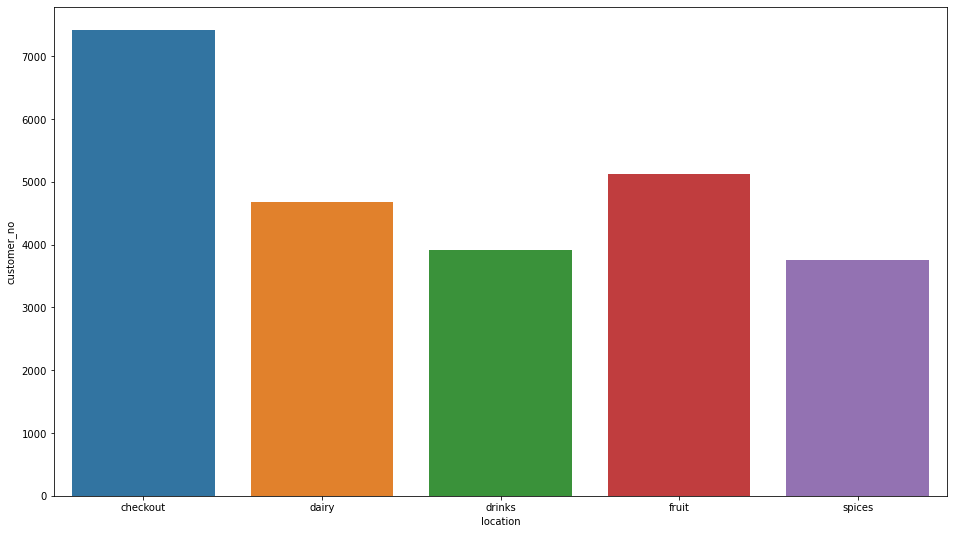

In [325]:
sns.barplot(x = customers_per_section.index, y = customers_per_section['customer_no'])

## Calculate the total number of customers in each section over time

In [326]:
supermarket.groupby(['timestamp', 'location']).count()

customer_no
timestamp           location             
2019-09-02 07:03:00 dairy               2
2019-09-02 07:04:00 dairy               2
                    fruit               1
                    spices              3
2019-09-02 07:05:00 checkout            2
...                                   ...
2019-09-06 21:50:00 checkout            2
                    dairy               1
                    drinks              1
                    fruit               1
                    spices              1

[13839 rows x 1 columns]

## Display the number of customers at checkout over time

In [327]:
checkout = supermarket[supermarket.location == 'checkout'].groupby('timestamp')[['customer_no']].count()
checkout 

,customer_no
timestamp,
2019-09-02 07:05:00,2
2019-09-02 07:06:00,2
2019-09-02 07:07:00,1
2019-09-02 07:08:00,3
2019-09-02 07:09:00,1
...,...
2019-09-06 21:37:00,1
2019-09-06 21:45:00,1
2019-09-06 21:47:00,2


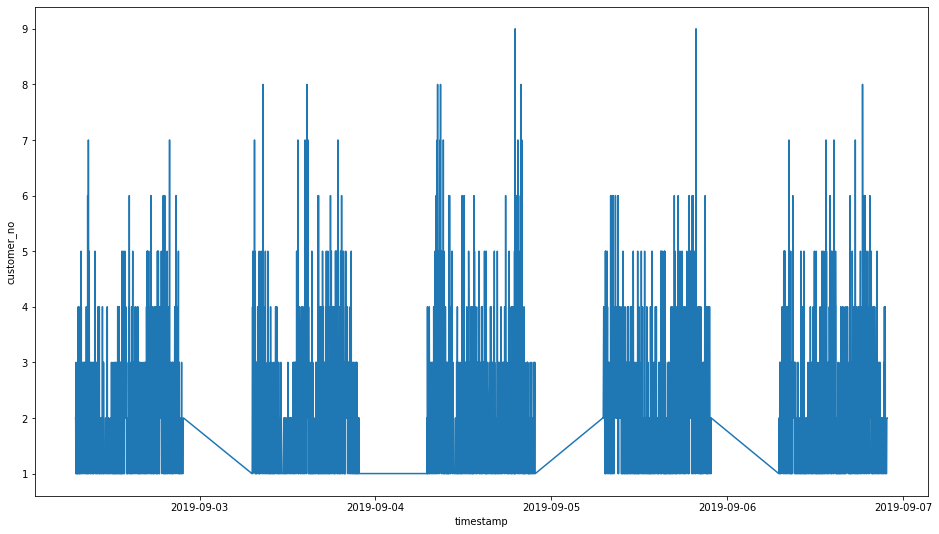

In [328]:
sns.lineplot(x = checkout.index, y = checkout.customer_no)

In [329]:
# This is super crowded so I will downsample to the hour
checkout_downsample_hour = checkout.resample('h').sum()
checkout_downsample_hour

,customer_no
timestamp,
2019-09-02 07:00:00,92
2019-09-02 08:00:00,112
2019-09-02 09:00:00,85
2019-09-02 10:00:00,90
2019-09-02 11:00:00,55
...,...
2019-09-06 17:00:00,115
2019-09-06 18:00:00,148
2019-09-06 19:00:00,135


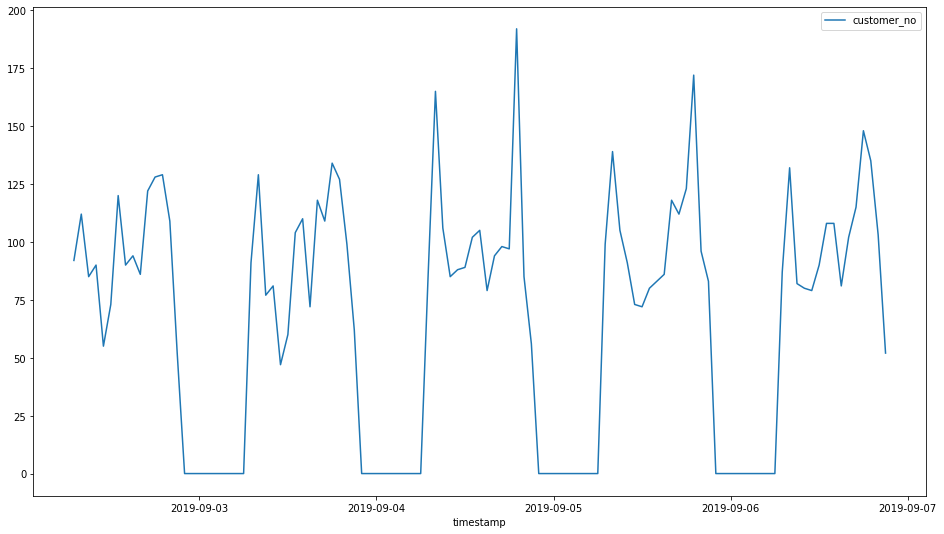

In [330]:
sns.lineplot(data = checkout_downsample_hour)

## Calculate the time each customer spent in the market

In [331]:
entry_time = supermarket.copy().reset_index().groupby('customer_no')['timestamp'].min()
exit_time = supermarket.copy().reset_index().groupby('customer_no')['timestamp'].max()
time_spent = pd.DataFrame(exit_time - entry_time).reset_index()
time_spent['time_spent'] = time_spent['timestamp'].astype(int)/ 60_000_000_000
time_spent

,customer_no,timestamp,time_spent
0,1,00:02:00,2.0
1,2,00:03:00,3.0
2,3,00:02:00,2.0
3,4,00:04:00,4.0
4,5,00:01:00,1.0
...,...,...,...
7440,41506,00:00:00,0.0
7441,41507,00:02:00,2.0
7442,41508,00:02:00,2.0
7443,41509,00:00:00,0.0


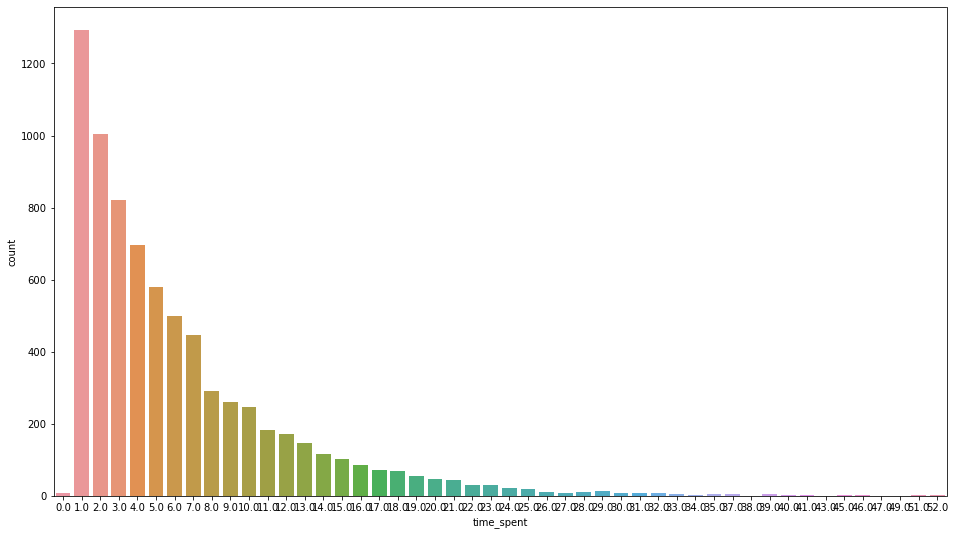

In [332]:
sns.countplot(x = 'time_spent', data = time_spent)

## Calculate the total number of customers in the supermarket over time

In [333]:
people_in_the_market_over_time = supermarket.groupby('timestamp').count()[['customer_no']]
people_in_the_market_over_time.columns = ['number_of_customers']
people_in_the_market_over_time.head()

,number_of_customers
timestamp,
2019-09-02 07:03:00,2
2019-09-02 07:04:00,6
2019-09-02 07:05:00,4
2019-09-02 07:06:00,8
2019-09-02 07:07:00,4


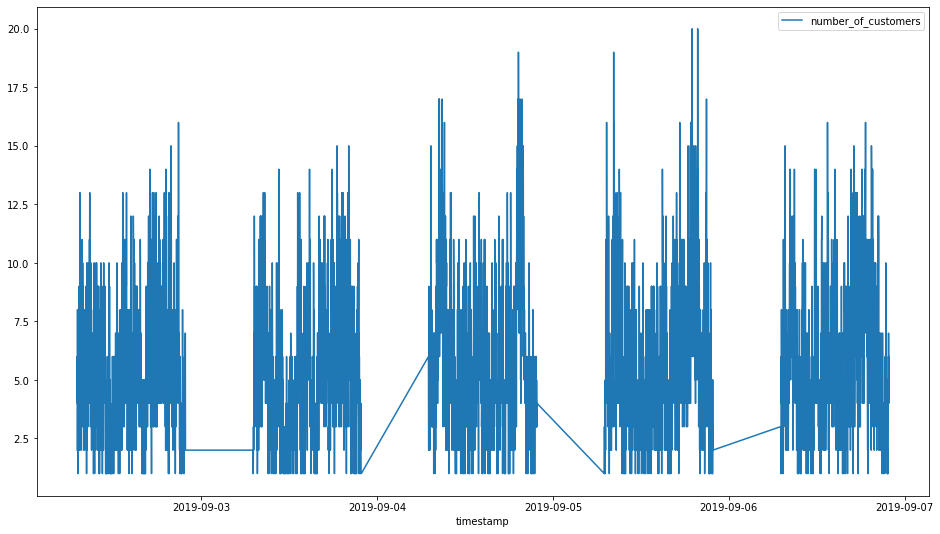

In [334]:
sns.lineplot(data=people_in_the_market_over_time)

## Our buiness managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first als "following")

In [335]:
sections_visited = supermarket.copy()
sections_visited['first'] = ~sections_visited.duplicated('customer_no')
sections_visited.head(10)

,customer_no,location,first
timestamp,,,
2019-09-02 07:03:00,1,dairy,True
2019-09-02 07:03:00,2,dairy,True
2019-09-02 07:04:00,3,dairy,True
2019-09-02 07:04:00,4,dairy,True
2019-09-02 07:04:00,5,spices,True
2019-09-02 07:04:00,6,spices,True
2019-09-02 07:04:00,7,spices,True
2019-09-02 07:04:00,8,fruit,True
2019-09-02 07:05:00,1,checkout,False


In [370]:
first_visited = sections_visited[sections_visited['first']]
first_visited_count = first_visited.groupby('location')[['customer_no']].count()
follow_visited = sections_visited[~sections_visited['first']]
follow_visited_count = follow_visited.groupby('location')[['customer_no']].count()

follow_visited_count

,customer_no
location,
checkout,7417
dairy,2538
drinks,2762
fruit,2312
spices,2403


In [359]:
first_visited_normalized = first_visited_count.copy()
first_visited_normalized.customer_no = first_visited_normalized.customer_no / (first_visited_normalized.customer_no).sum()
first_visited_normalized

,customer_no
location,
dairy,0.287576
drinks,0.153526
fruit,0.377435
spices,0.181464


In [360]:
follow_visited_normalized = follow_visited_count.copy()
follow_visited_normalized.customer_no = follow_visited_normalized.customer_no / (follow_visited_normalized.customer_no).sum()
follow_visited_normalized

,customer_no
location,
checkout,0.425482
dairy,0.145594
drinks,0.158444
fruit,0.132630
spices,0.137850


In [361]:
visted_locations = follow_visited_normalized.copy()
visted_locations.columns = ['follow']
visted_locations['first'] = first_visited_normalized
visted_locations

,follow,first
location,,
checkout,0.425482,NaN
dairy,0.145594,0.287576
drinks,0.158444,0.153526
fruit,0.132630,0.377435
spices,0.137850,0.181464


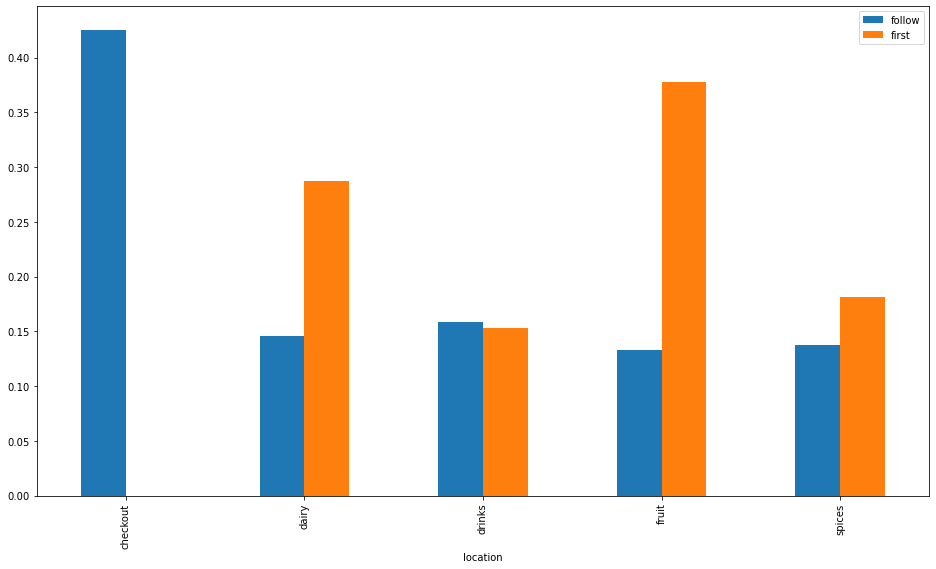

In [362]:
visted_locations.plot.bar()

In [363]:
get_transition_matrix(supermarket)

next_isle,checkout,dairy,drinks,fruit,spices
location,,,,,
dairy,0.391211,0.000000,0.223151,0.189925,0.195713
drinks,0.537023,0.027159,0.000000,0.219062,0.216756
fruit,0.499511,0.238319,0.136266,0.000000,0.125904
spices,0.251000,0.323553,0.273140,0.152307,0.000000


In [364]:
first_visited

,customer_no,location,first
timestamp,,,
2019-09-02 07:03:00,1,dairy,True
2019-09-02 07:03:00,2,dairy,True
2019-09-02 07:04:00,3,dairy,True
2019-09-02 07:04:00,4,dairy,True
2019-09-02 07:04:00,5,spices,True
...,...,...,...
2019-09-06 21:48:00,41506,dairy,True
2019-09-06 21:48:00,41507,dairy,True
2019-09-06 21:48:00,41508,dairy,True


In [365]:
get_transition_matrix(first_visited)

""


In [366]:
get_transition_matrix(follow_visited)

next_isle,checkout,dairy,drinks,fruit,spices
location,,,,,
dairy,0.386319,0.000000,0.209569,0.206406,0.197707
drinks,0.534227,0.013401,0.000000,0.223832,0.228540
fruit,0.495449,0.230603,0.140876,0.000000,0.133073
spices,0.245936,0.319717,0.276365,0.157982,0.000000
